In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdp_tut_functions as mdp43wa
import env_functions as ef
from rl_utils import running_mean, discount_rwds

# set seed for pseudorandom number generation -- make sure our trajectories look the same
np.random.seed(80)

%matplotlib inline

from importlib import reload

In [2]:
#
state=8
action=8
range(-3,3)
def state_reward_action(state,action):
    reward_matrix=np.random.randint(5,size=(state,action))
    print(f'state reward action:{reward_matrix}')
    return

In [3]:
state_reward_action(8,8)

state reward action:[[4 3 2 2 3 3 1 2]
 [4 0 1 1 4 2 4 3]
 [4 2 4 3 1 0 0 0]
 [3 3 2 0 3 2 2 1]
 [0 4 0 1 0 4 1 1]
 [1 0 1 4 0 3 0 3]
 [3 2 0 3 3 3 0 4]
 [3 3 4 0 3 1 0 0]]


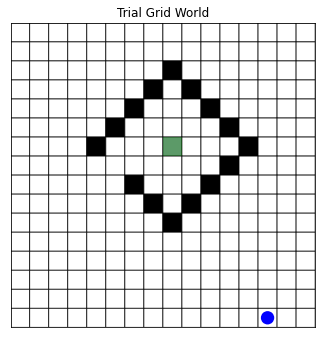

In [4]:
#CREATING AN ENVIRONMENT
#Obstacles are the black squares
#Reward is the green square
#Learning Agent is the blue circle moving randomly
#the terminal is in the same position as the reward so when the learning agent gets there it will stop and not move again.
n_rows,n_cols = 16,16
step_penalization=-0.01
gw_obst = ef.GridWorld(rows=n_rows,cols=n_cols,
                  obstacles=[(6,4),(5,5),(4,6),(3,7),(2,8),(3,9),(4,10),(5,11),(6,12),(7,11),(8,10),(9,9),(10,8),(9,9),(9,7),(8,6)], 
                  rewards={(6,8):10},
                  terminals=[(6,8)],
                  step_penalization=step_penalization,
                  actionlist=['Down','Up','Right','Left'],
                  view_labels=False
                 )

#obst_gw_steps,obst_gw_rwds = navigate(gw_obst, random_walker)


In [5]:
print(gw_obst.P[2,3,:])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [6]:
class TabularAgent(object):
    def __init__(self, nstates, nactions, 
                 learning_rate=0.1, discount=0.9, epsilon=1.0):
        
        self.num_actions = nactions
        self.action_space = np.arange(self.num_actions)

        # this agent selects actions from a table of state,action values which we initalize randomly
        #self.q_table = np.random.uniform(low=-1, high=1, size=(nstates, nactions))
        self.q_table = np.zeros((gw_obst.nstates, gw_obst.nactions))

        # parameters for learning
        self.epsilon       = epsilon
        self.learning_rate = learning_rate
        self.discount      = discount
        
    def choose_action(self, state):
        # this agent uses epsilon-greedy action selection, meaning that it selects 
        # the greedy (highest value) action most of the time, but with epsilon probability
        # it will select a random action -- this helps encourage the agent to explore
        # unseen trajectories
        
        ## TO DO -- write action selection for an epsilon-greedy policy 
        if np.random.random()>self.epsilon:
            # take the action which corresponds to the highest value in the q table at that row (state)
            action = np.argmax(self.q_table[state])
        else:
            action = np.random.choice(self.action_space)
        return action
    
  

In [7]:
  # MC Learning of the state value function
class MC_Agent(TabularAgent):
    def __init__(self, nstates,nactions, learning_rate=0.1, discount=0.95, epsilon=1.0):
        super().__init__(nstates,nactions, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

    def update_q_table(self, current_state, current_action, computed_return):
        # this function describes how the Q table gets updated so the agent can make 
        # better choices based on what it has experienced from the environment 
        current_q = self.q_table[current_state, current_action]
        
        ## TO DO -- write the Q value update step

        new_q = current_q + self.learning_rate*(computed_return-current_q)
        self.q_table[current_state, current_action] = new_q
        
    def navigate(self, gw_obst, num_episodes, random_start=False, start=0):
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)

        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking=[]
        max_steps= 1000

        for episode in range(num_episodes):
            gw_obst.reset()
            # initalize reward counter
            total_reward=0

            # get first state and action
            if random_start:
                state=np.random.choice(gw_obst.nstates)
            else:
                state=start
            
            states, actions, rewards = [], [], []
            for step in range(max_steps):
                action = self.choose_action(state)
                # take a step in the environment
                next_state, reward, done, _ = gw_obst.step(action)

                total_reward+=reward

                if not done:
                    states.append(state)
                    actions.append(action)
                    rewards.append(reward)
                else:
                    break
                state=next_state
            
            # compute return
            returns = discount_rwds(rewards)
            for i in range(len(states)):
                self.update_q_table(states[i],actions[i],returns[i])
            
            reward_tracking.append(total_reward)

            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking

In [8]:
class Q_Agent(TabularAgent):
    def __init__(self, nstates,nactions, learning_rate=0.1, discount=0.95, epsilon=1.0):
        super().__init__(nstates,nactions, learning_rate=learning_rate , discount=discount, epsilon=epsilon)

    def update_q_table(self, current_state, current_action, reward, new_state):
        # this function describes how the Q table gets updated so the agent can make 
        # better choices based on what it has experienced from the environment 
        current_q = self.q_table[ current_state, current_action]
        max_future_q = np.max(self.q_table[new_state,:])
        
        ## TO DO -- write the Q value update using Q-learning
        new_q = current_q + self.learning_rate*(reward+self.discount*max_future_q-current_q)
        self.q_table[current_state, current_action] = new_q
        
    def navigate(self, gw_obst, num_episodes, random_start=False, start=0):
        # set how we will decay the randomness of action selection over the course of training
        start_eps_decay = 1
        end_eps_decay = num_episodes//2
        epsilon_decay_value = self.epsilon/(end_eps_decay-start_eps_decay)

        # initialize empty list for keeping track of rewards achieved per episode
        reward_tracking=[]
        max_steps= 1000

        for episode in range(num_episodes):
            gw_obst.reset()
            # initalize reward counter
            total_reward=0

            # get first state and action
            if random_start:
                state=np.random.choice(gw_obst.nstates)
            else:
                state=start

            for step in range(max_steps):
                action = self.choose_action(state)
                # take a step in the environment
                next_state, reward, done, _ = gw_obst.step(action)

                total_reward+=reward

                if not done:
                    self.update_q_table(state, action, reward, next_state)
                else:
                    self.q_table[state, action] = 0
                    break
                state=next_state

            reward_tracking.append(total_reward)

            if end_eps_decay >= episode >= start_eps_decay:
                self.epsilon -= epsilon_decay_value

        return reward_tracking

In [9]:
# Visualizing the reward function another way
def plot_reward_map(gw_obs):
    R_map = plt.imshow(gw_obs.R.reshape(n_rows,n_cols))
    plt.colorbar(R_map)
    plt.show()
    
#plot_reward_map(gw_open)

Reward Function in Environment:


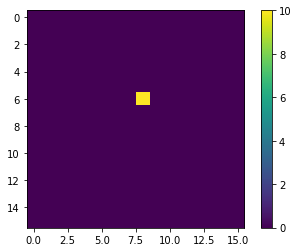

Running MC Agent...
Done
Running Q-Learning Agent...
Done


In [10]:
## let's look at the reward function on the environment:
print('Reward Function in Environment:')
plot_reward_map(gw_obst)

number_of_episodes = 5000

## run the MC agent through the environment
mc_learner = MC_Agent(gw_obst.nstates, gw_obst.nactions)
print('Running MC Agent...'),
mc_rewards = mc_learner.navigate(gw_obst, num_episodes=number_of_episodes)
print('Done')

## run the Q learning agent through the environment 
q_learner = Q_Agent(gw_obst.nstates, gw_obst.nactions)
print('Running Q-Learning Agent...')
q_rewards = q_learner.navigate(gw_obst, num_episodes=number_of_episodes)
print('Done')


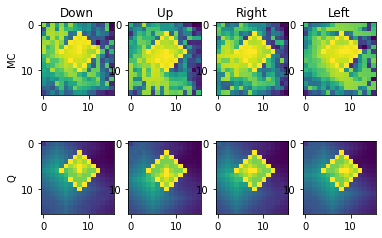

In [11]:


## Compare Values Learned by Agents 
fig, ax = plt.subplots(2,gw_obst.nactions)
for i in range(gw_obst.nactions):
    ax[0,i].imshow(mc_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[1,i].imshow(q_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[0,i].set_title(gw_obst.action_list[i])

ax[0,0].set_ylabel('MC')#ax[1,0].set_ylabel('Q')
ax[1,0].set_ylabel('Q')
plt.show()

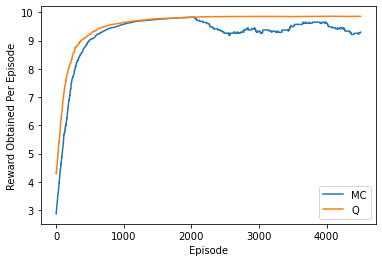

In [12]:
smooth=500
plt.plot(running_mean(mc_rewards,smooth), label='MC')
plt.plot(running_mean(q_rewards,smooth),label='Q')
plt.legend(loc=0)
plt.xlabel('Episode')
plt.ylabel('Reward Obtained Per Episode')
plt.show()

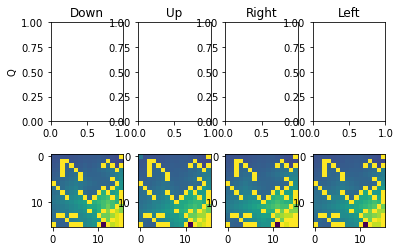

In [161]:
fig, ax = plt.subplots(2,gw_obst.nactions)
for i in range(gw_obst.nactions):
    ax[1,i].imshow(q_learner.q_table[:,i].reshape(n_rows,n_cols))
    ax[0,i].set_title(gw_obst.action_list[i])


ax[0,0].set_ylabel('Q')
plt.show()